In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from solver import *

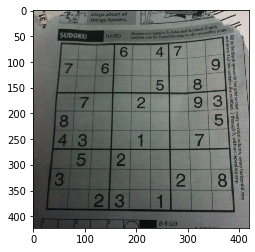

In [2]:
image = cv2.imread('1.jpg')
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image)

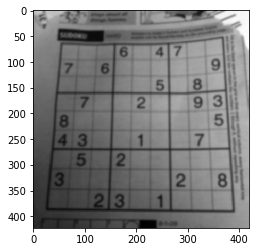

In [9]:
blur_image = cv2.GaussianBlur(gray_image,(9,9),0)
plt.imshow(blur_image, cmap='gray')

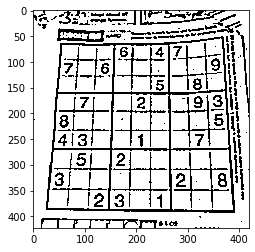

In [10]:
thresh = cv2.adaptiveThreshold(blur_image,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11 , 2)
plt.imshow(thresh, cmap='gray')

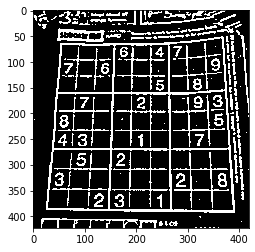

In [14]:
binary_image = cv2.bitwise_not(thresh,thresh)
plt.imshow(binary_image, cmap = 'gray')

In [15]:
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
dilated_image = cv2.dilate(binary_image, kernel)
plt.imshow(dilated_image, cmap = 'gray')

error: OpenCV(4.1.1) C:/projects/opencv-python/opencv/modules/imgproc/src/morph.simd.hpp:649: error: (-215:Assertion failed) _kernel.type() == CV_8U in function 'cv::opt_AVX2::`anonymous-namespace'::MorphFilter<struct cv::opt_AVX2::`anonymous namespace'::MaxOp<unsigned char>,struct cv::opt_AVX2::A0xf0ee8a47::MorphVec<struct cv::opt_AVX2::`anonymous namespace'::VMax<struct cv::hal_AVX2::v_uint8x32> > >::MorphFilter'


In [155]:
line_image = binary_image
temp = image
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(line_image,1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(temp,(x1,y1),(x2,y2),(0,255,0),1)

In [156]:
'''cv2.imshow('',temp)
cv2.waitKey()
cv2.destroyAllWindows()'''

"cv2.imshow('',temp)\ncv2.waitKey()\ncv2.destroyAllWindows()"

In [157]:
contours, hierarchy = cv2.findContours(line_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#contour_image = cv2.drawContours(image, contours, -1, (0,255,0), 1)

In [158]:
area = -1
for i in range(len(contours)):
    if cv2.contourArea(contours[i])>area:
        area = cv2.contourArea(contours[i])
        index = i
        #print('area:',area)
        #print('index:',i)
max_area = area

In [159]:
temp2 = image
contour_image = cv2.drawContours(temp2,[contours[index]],0, (0,0,255),2)
'''cv2.imshow('',contour_image)
cv2.waitKey()
cv2.destroyAllWindows()'''

"cv2.imshow('',contour_image)\ncv2.waitKey()\ncv2.destroyAllWindows()"

In [160]:
cnt = contours[index]
epsilon = 0.1*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)

In [161]:
def warp_coord(pts1):
    pts2 = [[0,0],[0,297],[297,0],[297,297]]
    ref = np.amax(pts1)//2
    pts1 = list(pts1)
    for i in range(len(pts1)):
        if pts1[i][0] < ref:
            if pts1[i][1] < ref:
                print('Top left coordinate:',pts1[i])
                pts2[i] = [0 , 0]
            elif pts1[i][1] > ref:
                print('Bottom left coordinate:',pts1[i])
                pts2[i] = [0, 297]
        elif pts1[i][0] > ref:
            if pts1[i][1] < ref:
                print('Top right coordinate:',pts1[i])
                pts2[i] = [297, 0]
            elif pts1[i][1] > ref:
                print('Bottom right coordinate:',pts1[i])
                pts2[i] = [297, 297]
    return np.float32(pts2)

In [162]:
pts1 = np.float32(approx.reshape(4,2))
pts2 = warp_coord(pts1)

Top right coordinate: [369.  51.]
Top left coordinate: [55. 63.]
Bottom left coordinate: [ 25. 387.]
Bottom right coordinate: [390. 392.]


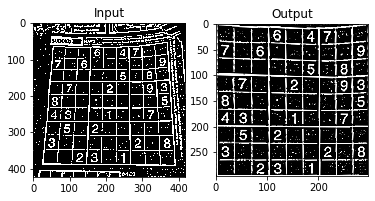

In [163]:
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(binary_image, M,(297,297))
plt.subplot(121),plt.imshow(binary_image,cmap='gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Output')
plt.show()

In [164]:
x_size, y_size = 33, 33
number_images = []
for y in range(1,10):
    for x in range(1,10):
        number_images.append(dst[(y-1)*y_size:y*y_size,(x-1)*x_size:x*x_size])

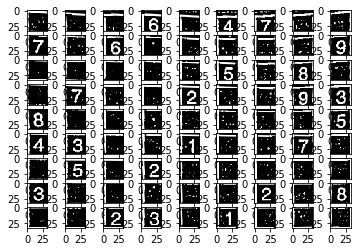

In [165]:
for i in range(81):
    plt.subplot(9,9,i+1), plt.imshow(number_images[i],cmap='gray')

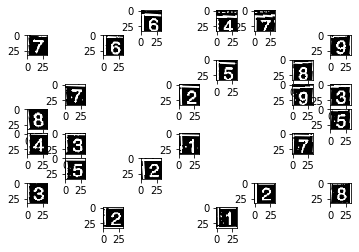

In [166]:
num_list = []
for i in range(81):
    if np.var(number_images[i][10:23,10:23]) > 10000:
        plt.subplot(9,9,i+1), plt.imshow(number_images[i],cmap='gray')
        num_list.append(i)

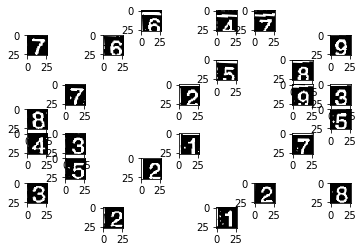

In [167]:
for i in range(81):
    if np.var(number_images[i][10:23,10:23]) > 10000:
        plt.subplot(9,9,i+1), plt.imshow(number_images[i][3:30,3:30],cmap='gray')

In [168]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [169]:
input_shape = (28,28,1)
num_classes = 10
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [170]:
model = load_model('mnist_model.h5')

In [171]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

c:\users\srikanth\appdata\local\programs\python\python37\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


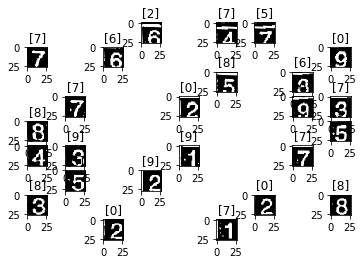

In [172]:
my_dict = {}
for index in num_list:
    buff = number_images[index][3:30,3:30]
    buff = cv2.resize(buff, (28,28))
    buff = buff.reshape(1,28,28,1)
    label = model.predict_classes(buff)
    my_dict[index] = label[0]
    #print('Block number:',index, '\t','Predicted number:',label)
    plt.subplot(9,9,index+1), plt.imshow(number_images[index][3:30,3:30],cmap='gray')
    plt.title(label)

In [173]:
sudoku = ['0' for i in range(81)]
for key, value in my_dict.items():
    sudoku[key] = str(value)
grid1 = ''.join(sudoku)

In [174]:
grid = '003020600900305001001806400008102900700000008006708200002609500800203009005010300'

In [177]:
answer = solve(grid)
answers = list(answer.items())

In [178]:
def write_to_image(image, item):
    row = item[0][0]
    column = item[0][1]
    value = item[1]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, value, (9+33*(int(column)-1), 25+33*(ord(row)-65)), font, 0.7, (0,255,0),2, cv2.LINE_AA)
    return image

In [200]:
final_image = cv2.warpPerspective(image,M,(297,297))
for i in range(81):
    if grid1[i]=='0' or grid1[i]=='.':
        frame = write_to_image(final_image, answers[i] )

In [203]:
cv2.imshow('',frame)
cv2.waitKey()
cv2.destroyAllWindows()

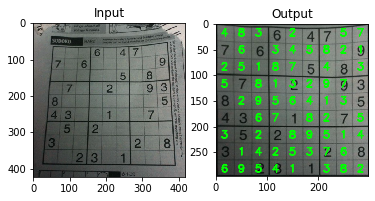

In [202]:
plt.subplot(121),plt.imshow(image,cmap='gray'),plt.title('Input')
plt.subplot(122),plt.imshow(final_image,cmap='gray'),plt.title('Output')
plt.show()

In [225]:
N = cv2.getPerspectiveTransform(pts2,pts1)
image.shape

(423, 419, 3)

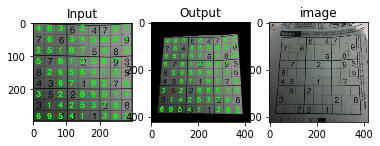

In [227]:
dst2 = cv2.warpPerspective(frame, N, image.shape[1::-1])
plt.subplot(131),plt.imshow(frame,cmap='gray'),plt.title('Input')
plt.subplot(132),plt.imshow(dst2,cmap='gray'),plt.title('Output')
plt.subplot(133), plt.imshow(image, cmap='gray'),plt.title('image')
plt.show()

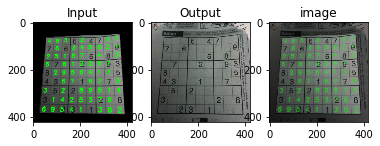

In [247]:
added_image = cv2.addWeighted(image,0.5,dst2,0.5,0.5)
plt.subplot(131),plt.imshow(dst2,cmap='gray'),plt.title('Input')
plt.subplot(132),plt.imshow(image,cmap='gray'),plt.title('Output')
plt.subplot(133), plt.imshow(added_image, cmap='gray'),plt.title('image')
plt.show()